In [8]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Set the random seed for reproducibility
torch.manual_seed(0)

In [9]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [10]:
train_images, _, train_labels, _ = train_test_split(
    train_dataset.data.numpy().reshape(-1, 28*28), 
    train_dataset.targets.numpy(), 
    test_size=0.9, 
    stratify=train_dataset.targets.numpy()
)

train_images = torch.tensor(train_images).float()
train_labels = torch.tensor(train_labels)

test_images = test_dataset.data.numpy().reshape(-1, 28*28)
test_labels = test_dataset.targets.numpy()


In [25]:
print('Train images shape:', train_images.shape)
print('Train labels shape:', train_labels.shape)
print('Test images shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: torch.Size([6000, 784])
Train labels shape: torch.Size([6000])
Test images shape: (10000, 784)
Test labels shape: (10000,)


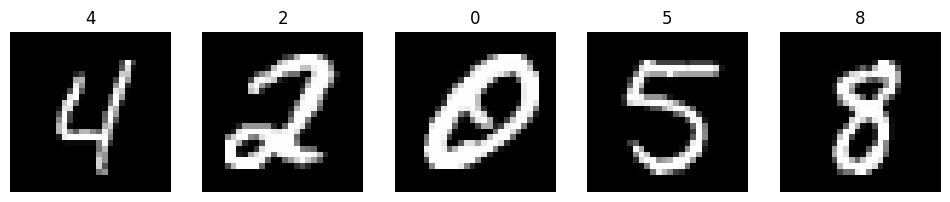

In [26]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    idx = random.randint(0, len(train_images))
    axes[i].imshow(train_images[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(train_labels[idx].item())
    axes[i].axis('off')
    
plt.show()

In [11]:
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()


In [12]:
# Training settings
num_epochs = 100
batch_size = 64
learning_rate = 0.001

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_images, train_labels), 
    batch_size=batch_size, 
    shuffle=True
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print_every = 10
    if (epoch+1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1474
Epoch [20/100], Loss: 0.0151
Epoch [30/100], Loss: 0.1480
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


/home/yash.bachwana/first/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MLP F1 Score: 0.9219609142279025
Random Forest F1 Score: 0.9429739233732107
Logistic Regression F1 Score: 0.8770835556960513


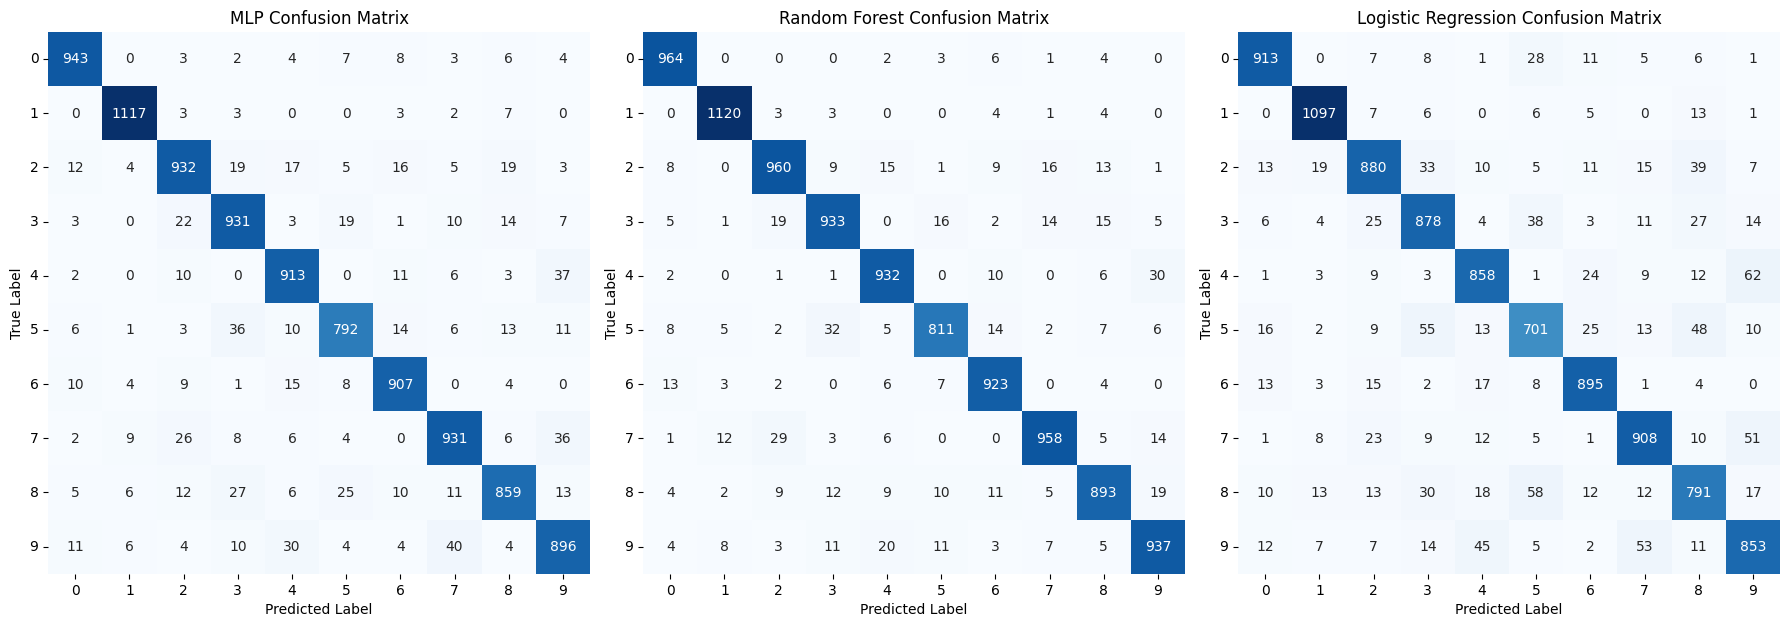

In [20]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Assuming previous code for MLP, Random Forest, and Logistic Regression is executed here

# Evaluate MLP
model.eval()
with torch.no_grad():
    test_images_tensor = torch.tensor(test_images).float()
    test_outputs = model(test_images_tensor)
    _, predicted = torch.max(test_outputs, 1)

# Compute metrics for MLP
f1_mlp = f1_score(test_labels, predicted.numpy(), average='weighted')
confusion_mlp = confusion_matrix(test_labels, predicted.numpy())

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(train_images.numpy(), train_labels.numpy())
rf_predicted = rf_model.predict(test_images)

# Compute metrics for Random Forest
f1_rf = f1_score(test_labels, rf_predicted, average='weighted')
confusion_rf = confusion_matrix(test_labels, rf_predicted)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_images.numpy(), train_labels.numpy())
lr_predicted = lr_model.predict(test_images)

# Compute metrics for Logistic Regression
f1_lr = f1_score(test_labels, lr_predicted, average='weighted')
confusion_lr = confusion_matrix(test_labels, lr_predicted)

# Display metrics
print(f'MLP F1 Score: {f1_mlp}')
print(f'Random Forest F1 Score: {f1_rf}')
print(f'Logistic Regression F1 Score: {f1_lr}')

# Function to plot confusion matrix
def plot_confusion_matrices(cm_list, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, cm, title in zip(axes, cm_list, titles):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, square=True)
        ax.set_title(title)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_xticks(ticks=np.arange(10) + 0.5)
        ax.set_xticklabels(np.arange(10), rotation=0)
        ax.set_yticks(ticks=np.arange(10) + 0.5)
        ax.set_yticklabels(np.arange(10), rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices in subplots
plot_confusion_matrices([confusion_mlp, confusion_rf, confusion_lr], 
                        titles=['MLP Confusion Matrix', 'Random Forest Confusion Matrix', 'Logistic Regression Confusion Matrix'])

In [22]:
from torchvision import datasets

# Load the Fashion-MNIST dataset
fashion_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fashion_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=fashion_transform)
fashion_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=fashion_transform)

# Use the same test set of 10,000 images for evaluation
fashion_test_images = fashion_test_dataset.data.numpy().reshape(-1, 28*28)
fashion_test_labels = fashion_test_dataset.targets.numpy()


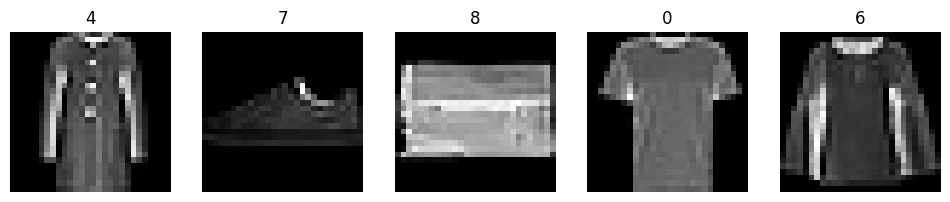

In [27]:
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    idx = random.randint(0, len(train_images))
    axes[i].imshow(fashion_test_images[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(fashion_test_labels[idx].item())
    axes[i].axis('off')
    
plt.show()

In [23]:
# Evaluate MLP on Fashion-MNIST
model.eval()
with torch.no_grad():
    fashion_test_images_tensor = torch.tensor(fashion_test_images).float()
    fashion_outputs = model(fashion_test_images_tensor)
    _, fashion_predicted = torch.max(fashion_outputs, 1)

# Compute metrics for Fashion-MNIST
f1_fashion_mlp = f1_score(fashion_test_labels, fashion_predicted.numpy(), average='weighted')
confusion_fashion_mlp = confusion_matrix(fashion_test_labels, fashion_predicted.numpy())

# Display metrics for Fashion-MNIST
print(f'MLP F1 Score on Fashion-MNIST: {f1_fashion_mlp}')


MLP F1 Score on Fashion-MNIST: 0.039106539061094125


/tmp/ipykernel_1671097/3004429450.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  # Use a colormap with 10 distinct colors


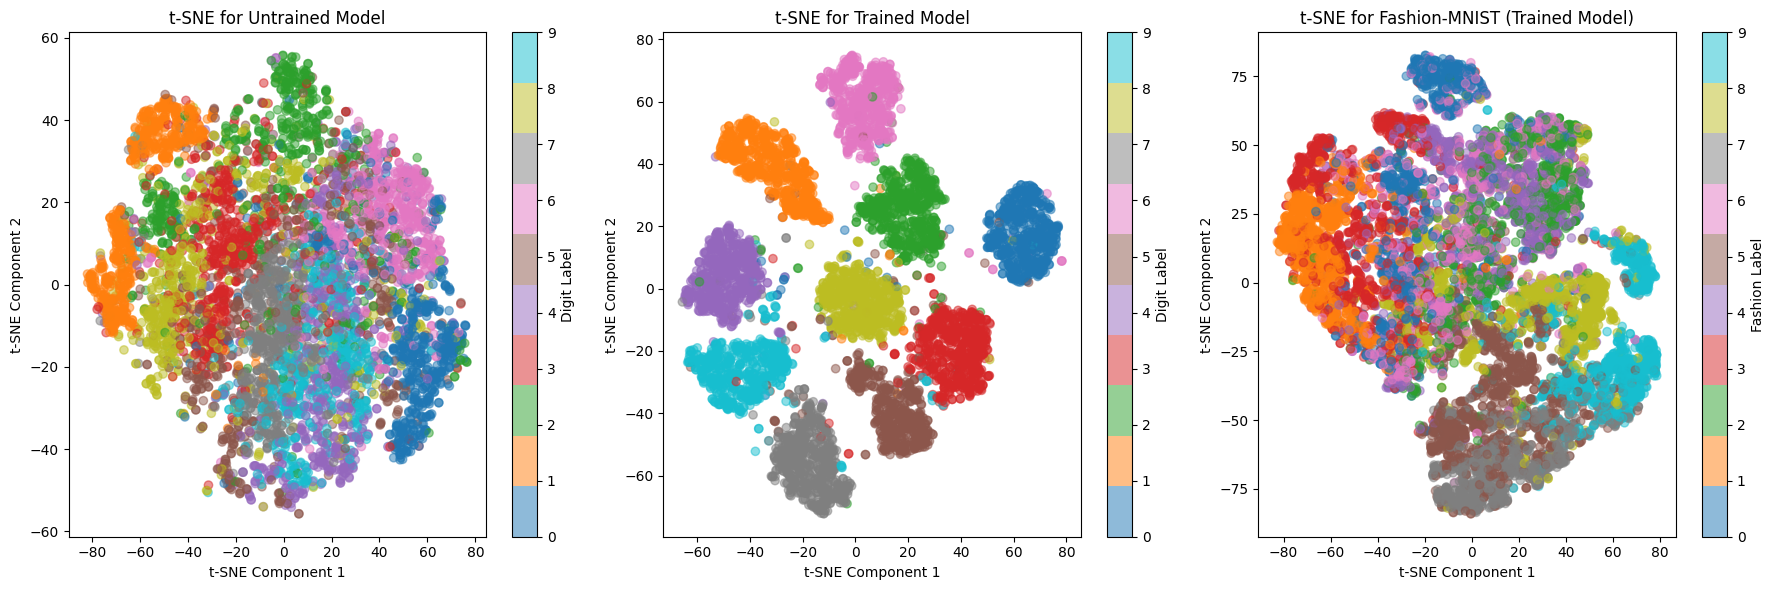

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get the output of the layer with 20 neurons
train_loader_untrained = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_images, train_labels), 
    batch_size=batch_size, 
    shuffle=False
)

# Get the features from the second layer of the untrained model
model_untrained = MLP()
features_untrained = []
labels_untrained = []

with torch.no_grad():
    for images, labels in train_loader_untrained:
        hidden = torch.relu(model_untrained.fc1(images))
        features_untrained.append(hidden)
        labels_untrained.append(labels)  # Collect labels

    features_untrained = torch.cat(features_untrained)
    labels_untrained = torch.cat(labels_untrained)

# Get the features from the second layer of the trained model
features_trained = []
labels_trained = []

with torch.no_grad():
    for images, labels in train_loader_untrained:
        hidden = torch.relu(model.fc1(images))
        features_trained.append(hidden)
        labels_trained.append(labels)  # Collect labels

    features_trained = torch.cat(features_trained)
    labels_trained = torch.cat(labels_trained)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_untrained_embedded = tsne.fit_transform(features_untrained)
features_trained_embedded = tsne.fit_transform(features_trained)

# Get the features from the second layer of the trained model for Fashion-MNIST
fashion_features = []
fashion_labels = []

with torch.no_grad():
    for i in range(0, len(fashion_test_images_tensor), batch_size):
        images = fashion_test_images_tensor[i:i+batch_size]
        hidden = torch.relu(model.fc1(images))
        fashion_features.append(hidden)

    fashion_features = torch.cat(fashion_features)

# Apply t-SNE on Fashion-MNIST features
fashion_tsne = TSNE(n_components=2, random_state=0)
fashion_features_embedded = fashion_tsne.fit_transform(fashion_features)

# Set up color mapping for digits
colors = plt.cm.get_cmap('tab10', 10)  # Use a colormap with 10 distinct colors

# Plot t-SNE
plt.figure(figsize=(18, 6))

# Untrained Model t-SNE
plt.subplot(1, 3, 1)
plt.title('t-SNE for Untrained Model')
scatter = plt.scatter(features_untrained_embedded[:, 0], features_untrained_embedded[:, 1], 
                      c=labels_untrained, cmap=colors, alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, ticks=np.arange(10), label='Digit Label')

# Trained Model t-SNE
plt.subplot(1, 3, 2)
plt.title('t-SNE for Trained Model')
scatter = plt.scatter(features_trained_embedded[:, 0], features_trained_embedded[:, 1], 
                      c=labels_trained, cmap=colors, alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, ticks=np.arange(10), label='Digit Label')

# t-SNE for Fashion-MNIST
plt.subplot(1, 3, 3)
plt.title('t-SNE for Fashion-MNIST (Trained Model)')
scatter = plt.scatter(fashion_features_embedded[:, 0], fashion_features_embedded[:, 1], 
                      c=fashion_test_labels, cmap='tab10', alpha=0.5)  # Change color mapping if needed
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, ticks=np.arange(10), label='Fashion Label')

plt.tight_layout()
plt.show()
